# XGBoost comparison
> Does XGBoost prefer mixture embeddings?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from util import load_task, mixture_embedding

INFO: Using numpy backend


In [3]:
N_DIM = 64

In [4]:
# Load embeddings

embed_dict = {}

for size in [2, 4, 8, 16, 32, 64, 128]:
    euc_embed = pd.read_csv(
        f"/home/phil/DATA/otu_embeddings/embeddings_euclidean_{size}.csv", 
        dtype={0: str}
    )
    euc_embed = euc_embed.set_index(euc_embed.columns[0])
    embed_dict[size] = euc_embed

In [59]:
# Preliminary experiment - we see embeddings do worse

def xgboost_experiment(X, y, **kwargs):
    model = xgb.XGBClassifier(**kwargs)
    return cross_val_score(model, X, y, cv=5)

dd = "/home/phil/mixture_embeddings/data/interim/mlrepo_clean/classification"

results = pd.DataFrame(
    columns=["task", "fold", "raw", "embed", "pca", "n_samples"], dtype=float
)

for subdir in os.listdir(dd):
    if not os.path.isdir(f"{dd}/{subdir}"):
        continue
    else:
        X, y = load_task(dd, subdir)
        acc = xgboost_experiment(X, y)

        # Embedding
        X_embed = mixture_embedding(X, euc_embed, geometry="euclidean")
        acc_embed = xgboost_experiment(X_embed, y)

        # PCA
        pca_dim = np.min([N_DIM, X.shape[0]])
        pca = PCA(n_components=pca_dim)
        X_pca = pca.fit_transform(X)
        acc_pca = xgboost_experiment(X_pca, y)

        # Push results
        for i in range(5):
            results.loc[len(results)] = [
                subdir, i, acc[i], acc_embed[i], acc_pca[i], X.shape[0]
            ]
results

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

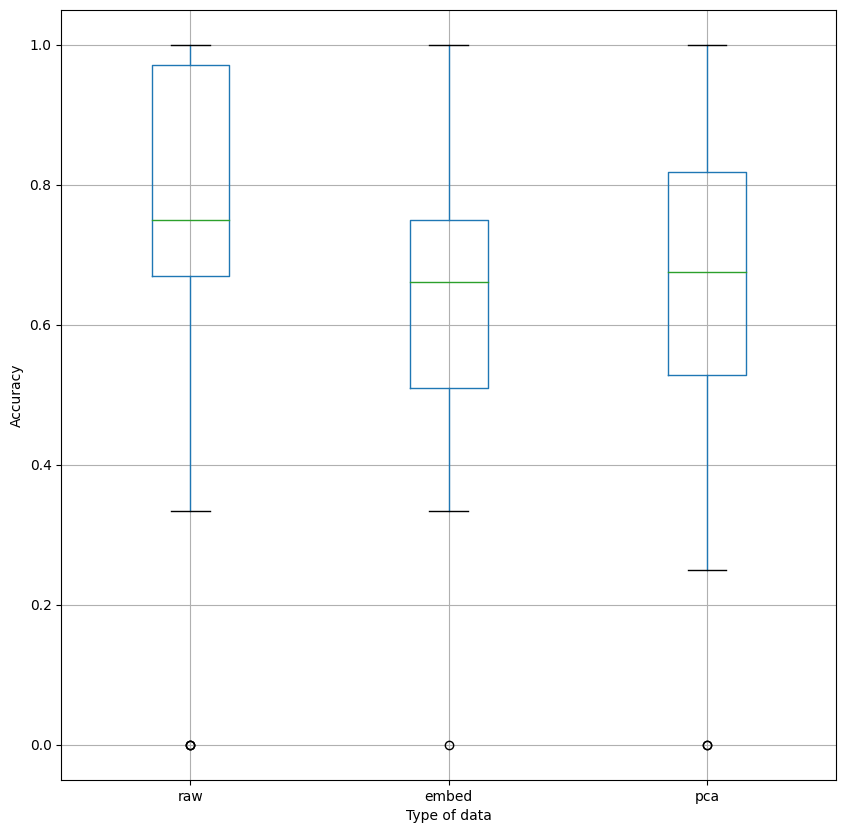

In [15]:
results.boxplot(column=["raw", "embed", "pca"], figsize=(10, 10))
plt.xlabel("Type of data")
plt.ylabel("Accuracy")

In [81]:
# Grid search: XGBoost on raw data - about 32 seconds per dataset

# class XGBClassifier_embed(xgb.XGBClassifier):
#     def __init__(self, **kwargs):
#         embed = kwargs.pop("embed", None)
#         self.model = super(XGBClassifier_embed, self).__init__(**kwargs)
#         self.embed = embed
    
#     def fit(self, X, y):
#         if self.embed is not None:
#             X = mixture_embedding(X, self.embed, geometry="euclidean")
#         return self.model.fit(X, y)

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.utils.multiclass import unique_labels

# embed_dict = {"euc_16": euc_embed}

class XGBClassifier_embed(BaseEstimator, ClassifierMixin):
    def __init__(self, embed=None, xgb_params=None):
        self.embed = embed
        self.xgb_params = xgb_params if xgb_params is not None else {}
        self.xgb_clf_ = xgb.XGBClassifier(**self.xgb_params)
        
    def fit(self, X, y):
        if self.embed is not None:
            X = mixture_embedding(
                X, embed_dict[self.embed], geometry="euclidean"
            ) # assuming this method is defined
        X, y = check_X_y(X, y)
        self.xgb_clf_.fit(X, y)
        self.classes_ = unique_labels(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        if self.embed is not None:
            X = mixture_embedding(
                X, embed_dict[self.embed], geometry="euclidean"
            )
            X = X.values
        return self.xgb_clf_.predict(X)

    def get_params(self, deep=True):
        return {'embed': self.embed, 'xgb_params': self.xgb_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

gs = GridSearchCV(
    XGBClassifier_embed(),
    # xgb.XGBClassifier(),
    param_grid={
        "embed": [None, euc_embed],
        "max_depth": [2, 4, 8, 16],
        "n_estimators": [10, 50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1.0],
    },
    cv=5,
    n_jobs=1,
    verbose=0,
)

results = []
for subdir in os.listdir(dd):
    if not os.path.isdir(f"{dd}/{subdir}"):
        continue
    else:
        X, y = load_task(dd, subdir)
        gs.fit(X, y)
        params_str = gs.best_params_
        if params_str["embed"] is not None:
            params_str["embed"] = params_str["embed"].shape
        print(subdir, len(X), f"{gs.best_score_:.3f}", gs.best_params_, sep="\t")

        # Store all scores
        all_scores = gs.cv_results_ # dict
        all_scores["task"] = subdir
        all_scores["n_samples"] = len(X)
        results.append(all_scores)

results = pd.concat(results)
results.to_csv("results_xgb_raw.csv", index=False)
results

ravel_black_hispanic	199	0.547	{'embed': (1262986, 64), 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
cho_control_ct_cecal	17	0.750	{'embed': None, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
kostic	172	0.708	{'embed': None, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
cho_penicillin_vancomycin_cecal	20	0.850	{'embed': None, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}


KeyboardInterrupt: 